<center><img src="data/car.jpg" width=500></center>


Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries insurance it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

(`Source: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf`) 

Knowing all of this, On the Road car insurance have requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [10]:
# Import required modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

- Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the `"outcome"` column), excluding the `"id"` column.
- Store as a DataFrame called `best_feature_df`, containing columns named "best_feature" and "best_accuracy" with the name of the feature with the highest accuracy, and the respective accuracy score.


In [11]:
from statsmodels.formula.api import logit

# Load the car insurance dataset from local file
cars = pd.read_csv(
    "https://raw.githubusercontent.com/jhlopesalves/data-science-practice-notebook/refs/heads/main/Python/projects/modeling_car_insurance_claim_outcomes/data/car_insurance.csv", 
    usecols=lambda col: not col.startswith("Unnamed"))

cars.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [12]:
# Data preprocessing and feature engineering

# 1. Ordinal variable encoding
# Map categorical variables to numeric values based on their natural ordering
category_map = {
    "driving_experience": {"0-9y": 1, "10-19y": 2, "20-29y": 3, "30+": 4},  # Years of experience (ascending order)
    "education": {"none": 0, "high school": 1, "university": 2},  # Education level (ascending order)
    "income": {"poverty": 0, "working class": 1, "upper class": 2},  # Income level (ascending order)
    "vehicle_year": {"before 2015": 0, "after 2015": 1},  # Vehicle age (older to newer)
}

# Apply ordinal encoding and convert to pandas Categorical type to preserve ordering
for col, mapping in category_map.items():
    # Map string categories to numeric values
    cars[col] = cars[col].map(mapping)
    # Convert to ordered categorical to maintain ordinal relationships for modeling
    cars[col] = pd.Categorical(
        cars[col], categories=list(range(len(mapping))), ordered=True
    )

# 2. Convert binary categorical variables to boolean type
# These variables have only two states (True/False), making boolean type more appropriate
cars[["married", "children", "vehicle_ownership"]] = cars[
    ["married", "children", "vehicle_ownership"]
].astype(bool)

# 3. Convert target variable to integer type
# Ensure the outcome variable is properly typed for logistic regression
cars["outcome"] = cars["outcome"].astype(int)

# 4. One-hot encode nominal categorical variable (vehicle_type)
# Create binary dummy variables for vehicle type since there's no natural ordering
# Also clean column names by replacing spaces with underscores
cars = pd.get_dummies(
    cars, columns=["vehicle_type"], prefix="vehicle", prefix_sep="_"
).rename(columns=lambda c: c.replace(" ", "_"))

In [13]:
# mean-impute the two columns with NaNs
for col in ["credit_score", "annual_mileage"]:
    cars[col] = cars[col].fillna(cars[col].mean())

In [ ]:
# Loop through each feature (excluding id and outcome) to find the best predictor
models = []
features = cars.drop(columns=["id", "outcome"]).columns

# Initialize list to store accuracy scores for each feature
accuracies = []

for feat in features:
    # Fit logistic regression model for each individual feature
    mdl = logit(f"outcome ~ {feat}", data=cars).fit(disp=False)
    models.append(mdl)
    
    # Calculate accuracy from confusion matrix
    # tn = true negatives, fp = false positives, fn = false negatives, tp = true positives
    tn, fp, fn, tp = mdl.pred_table().ravel()
    accuracy = (tn + tp) / (tn + tp + fn + fp)  # (correct predictions) / (total predictions)
    accuracies.append(accuracy)

# Find the feature with the highest accuracy and create result dataframe
best_feature_index = accuracies.index(max(accuracies))
best_feature_df = pd.DataFrame(
    {"best_feature": [features[best_feature_index]],
     "best_accuracy": [max(accuracies)]}
)

best_feature_df  # Display the best feature and its accuracy


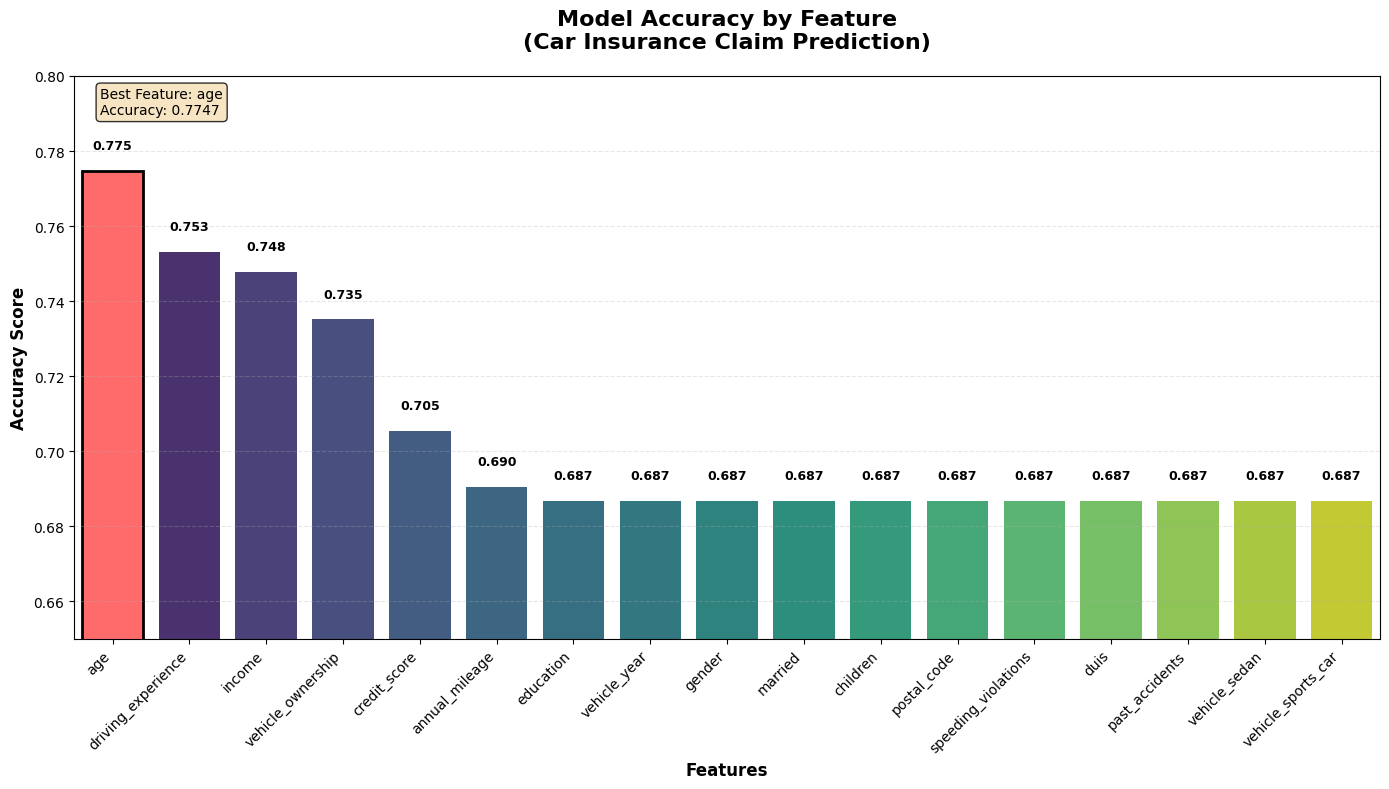

In [20]:
# Create a DataFrame with features and their corresponding accuracies for plotting
accuracy_df = pd.DataFrame({
    'feature': features,
    'accuracy': accuracies
})

# Sort the accuracy_df by accuracy for better visualization
accuracy_df_sorted = accuracy_df.sort_values('accuracy', ascending=False)

# Create a more polished and informative plot
fig, ax = plt.subplots(figsize=(14, 8))

# Create the bar plot with a color palette 
bars = sns.barplot(data=accuracy_df_sorted, x='feature', y='accuracy', ax=ax, palette="viridis", hue="feature")

# Highlight the best feature
bars.patches[0].set_color('#FF6B6B')
bars.patches[0].set_edgecolor('black')
bars.patches[0].set_linewidth(2)

# Customize the plot
ax.set_title('Model Accuracy by Feature\n(Car Insurance Claim Prediction)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')

# Add value labels on top of bars
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Rotate x-axis labels and improve readability
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0.65, 0.80)

# Add a text box highlighting the best feature
textstr = f'Best Feature: {accuracy_df_sorted.iloc[0]["feature"]}\nAccuracy: {accuracy_df_sorted.iloc[0]["accuracy"]:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Improve layout and display
plt.tight_layout()
plt.show()
